###### Feature Information

PassengerID: Unique ID number

Survived: 0 = No, 1 = Yes

Pclass: Ticket class (1, 2, or 3)

Name: Passenger name

Sex: Male or Female

Age: Age in years

SibSp: # of siblings/spouses aboard the Titanic

Parch: # of parents/children aboard the Titanic

Ticket: Ticket #

Fare: Passenger fare

Cabin: Cabin number

Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Imports

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Obtain

Load train & test data as dataframes from csv files

In [2]:
# Import training/testing data using pandas

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_index = test.PassengerId

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Scrub

Check training data features for any null values or non-numeric data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


###### There are several immediate issues with the data:

1) Missing (null) values in the 'Age', 'Cabin', and 'Embarked' features

2) Non-numeric data is present in the 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked' features.

The points should be addressed before further meaningful data analysis is performed.

###### 1) Handing 'Age' missing values

In [6]:
# Check value counts of age

train.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BD6D78E9E8>]],
      dtype=object)

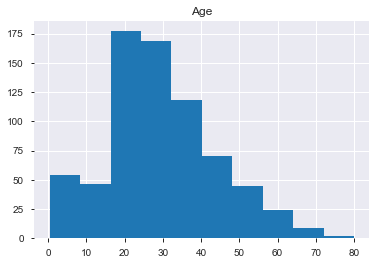

In [7]:
train.hist('Age')

In [8]:
# How many ages are missing?

train.Age.isna().sum()

177

In [9]:
# Replace nulls with median value for age

train.Age.fillna(train.Age.median(), inplace=True)

In [10]:
# Separate age data into bins for every 10 years, to smooth the effect of
# filling null ages with median age

train['age_bins'] = pd.cut(x=train['Age'], 
                           bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],
                          labels=[5, 15, 25, 35, 45, 55, 65, 75])

In [11]:
# Convert data type to numeric

train['age_bins'] = train['age_bins'].astype('int64')

In [12]:
# Check updated value counts for age (25 = 20-30 yr bin)

train['age_bins'].value_counts()

25    407
35    155
15    115
45     86
5      64
55     42
65     17
75      5
Name: age_bins, dtype: int64

###### 2) Handle 'Cabin' missing values

Since most of the data is missing, it is best to drop this feature entirely

In [13]:
# Drop cabin feature

train.drop('Cabin', axis=1, inplace=True)

In [14]:
# Check to make sure 'Cabin' removed

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_bins
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,35
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,25
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,35
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,35


###### 3) Handle 'Embarked' missing values

In [15]:
# Let's see the distribution of values for 'Embarked'

train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
# Since most people embarked at 'S', we will fill the two null values with 'S'

train.Embarked.fillna('S', inplace=True)

train.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [17]:
dummies = pd.get_dummies(train.Embarked, prefix='Emb', drop_first=True)

In [18]:
train = pd.concat([train, dummies], axis=1)

In [19]:
train.drop('Embarked', axis=1, inplace=True)

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,age_bins,Emb_Q,Emb_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,25,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,35,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,25,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,35,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,35,0,1


###### 4) Handling 'Sex' dtype

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [21]:
s_dummies = pd.get_dummies(train.Sex, prefix='sex', drop_first=True)
train = pd.concat([train, s_dummies], axis=1)
train.drop('Sex', axis=1, inplace=True)

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,age_bins,Emb_Q,Emb_S,sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,25,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,35,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,25,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,35,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,35,0,1,1


###### 5) Handling 'Name' and 'Ticket' features

Since I don't see any real way to extract meaningful information from these, I will drop these from my training data.

In [23]:
train.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [24]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age_bins,Emb_Q,Emb_S,sex_male
0,1,0,3,22.0,1,0,7.2500,25,0,1,1
1,2,1,1,38.0,1,0,71.2833,35,0,0,0
2,3,1,3,26.0,0,0,7.9250,25,0,1,0
3,4,1,1,35.0,1,0,53.1000,35,0,1,0
4,5,0,3,35.0,0,0,8.0500,35,0,1,1


###### Final check of first pass at scrubbing

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
age_bins       891 non-null int64
Emb_Q          891 non-null uint8
Emb_S          891 non-null uint8
sex_male       891 non-null uint8
dtypes: float64(2), int64(6), uint8(3)
memory usage: 58.4 KB


# Explore

Taking another look at each variable, so see if anything needs bo be adjusted before beginning modeling.

In [26]:
# Run pandas profiling report on our scrubbed training dataset

pp.ProfileReport(train)

I am now going to drop the 'Age' and 'PassengerId' features. 'Age' is highly correlated to 'age_bins' and will therefore be redundant, an 'PassengerId' isn't going to provide any useful information.

In [27]:
train.drop(['Age', 'PassengerId'], axis=1, inplace=True)

In [28]:
train.head()

,Survived,Pclass,SibSp,Parch,Fare,age_bins,Emb_Q,Emb_S,sex_male
0,0,3,1,0,7.2500,25,0,1,1
1,1,1,1,0,71.2833,35,0,0,0
2,1,3,0,0,7.9250,25,0,1,0
3,1,1,1,0,53.1000,35,0,1,0
4,0,3,0,0,8.0500,35,0,1,1


In [29]:
pp.ProfileReport(train)

## Feature Engineering

I want to see if being alone or with family has any real impact on predicting whether someone survived. I will create a new column called 'Alone', which will be dependent on whether the passenger had any non-zero result in the 'SibSp' or the 'Parch' categories. I will then keep the 'Alone' column in place of 'SibSp' and 'Parch' for simplicity.

In [30]:
train['Alone'] = np.where((train['SibSp'] + train['Parch']) == 0, 1, 0)
train.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [31]:
train.head()

,Survived,Pclass,Fare,age_bins,Emb_Q,Emb_S,sex_male,Alone
0,0,3,7.2500,25,0,1,1,0
1,1,1,71.2833,35,0,0,0,0
2,1,3,7.9250,25,0,1,0,1
3,1,1,53.1000,35,0,1,0,0
4,0,3,8.0500,35,0,1,1,1


# Model

First, let's assign our features and target to X and y

In [32]:
X = train.drop('Survived', axis=1)
y = train.Survived

Next, let's define a function to perform KFold cross validation for any classifier we want to use, and returns the accuracy score for each split as well as the mean cross validation accuracy.

In [33]:
def cross_val_acc(X, y, classifier, n_splits, random_state=None):
    
    from sklearn.model_selection import KFold
    from sklearn.metrics import accuracy_score
    
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    scores = []
    for train_index, test_index in cv.split(X):
        classifier.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = classifier.predict(X.iloc[test_index])
        y_true = y.iloc[test_index]
        scores.append(accuracy_score(y_true, y_pred))

    print(f"Accuracy Scores: {scores}")
    print(f"Mean Cross Val. Acc.: {round(np.mean(scores), 2)}")

## Zero Rule (ZeroR) Classifier

This is a great baseline classifier for a binary classification problem like this. The ZeroR classifier simply predicts the majority class in your dataset (i.e., mode).

In [34]:
zero_r_clf = round(len(train.loc[train.Survived == 0]) / len(train), 2)

In [35]:
print(f"ZeroR (Baseline) Classifier Accuracy is: {zero_r_clf}")

ZeroR (Baseline) Classifier Accuracy is: 0.62


So, the baseline ZeroR classifier (which only predicts the majority class) will be right about 62% of the time. This is a good starting point for more sophisticated classifiers.

## Decision Tree Classifier

In [36]:
# Instantiate a vanilla decision tree clf

dt_clf = DecisionTreeClassifier(random_state=1)

In [37]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, dt_clf, n_splits=5, random_state=1)

Accuracy Scores: [0.7653631284916201, 0.7921348314606742, 0.7865168539325843, 0.8258426966292135, 0.8202247191011236]
Mean Cross Val. Acc.: 0.8


A vanilla Decision Tree classifier can achieve an accuracy of ~ 80% using 5-Fold cross validation on the training dataset. This  is about an 18% classification accuracy improvement over the ZeroR classifier.

## Random Forest Classifier

In [38]:
# Instantiate a random forest classifier

rf_clf = RandomForestClassifier(random_state=1)

In [39]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, rf_clf, n_splits=5, random_state=1)

Accuracy Scores: [0.7821229050279329, 0.7921348314606742, 0.8314606741573034, 0.8370786516853933, 0.8426966292134831]
Mean Cross Val. Acc.: 0.82


A vanilla random forest classifier can achieve an accuracy of ~ 82% using 5-Fold cross validation on the training dataset. This  is about an 20% classification accuracy improvement over the ZeroR classifier.

## XGBoost Classifier

In [40]:
# Instantiate an xg boost classifier

xgb_clf = XGBClassifier(random_state=1)

In [41]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, xgb_clf, n_splits=5, random_state=1)

Accuracy Scores: [0.7932960893854749, 0.8033707865168539, 0.8370786516853933, 0.848314606741573, 0.8539325842696629]
Mean Cross Val. Acc.: 0.83


The vanilla XGBoost classifier can achieve an accuracy of ~ 83% using 5-Fold cross validation on the training dataset. This  is about an 21% classification accuracy improvement over the ZeroR classifier.

## Logistic Regression Classifier

In [42]:
# Instantiate logistic regression classifier

lr_clf = LogisticRegression(random_state=1)

In [43]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, lr_clf, n_splits=5, random_state=1)

Accuracy Scores: [0.7486033519553073, 0.7528089887640449, 0.8146067415730337, 0.8202247191011236, 0.7921348314606742]
Mean Cross Val. Acc.: 0.79


The vanilla Logistic Regression classifier can achieve an accuracy of ~ 79% using 5-Fold cross validation on the training dataset. This  is about an 18% classification accuracy improvement over the ZeroR classifier.

## XGBoost with GridSearchCV

In [44]:
# Perform grid search with GridSearchCV to try to find optimal parameters

xgb = XGBClassifier(random_state=1)

grid = {'booster': ['gbtree', 'gblinear', 'dart'], 'max_depth': [3, 5, 10], 
        'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [75, 100, 125],
       'subsample': [0.8, 0.9, 1]}

clf = GridSearchCV(xgb, grid, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 1

In [45]:
# View best parameters found in grid search

best_xgb_params = clf.best_params_

best_xgb_params

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 75,
 'subsample': 0.8}

Checking best XGBoost params with a manual grid search

In [46]:
# Instantiate an xg boost classifier with tuned params

xgb_clf = XGBClassifier(random_state=1, **clf.best_params_)

In [47]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, xgb_clf, n_splits=5, random_state=1)

Accuracy Scores: [0.7877094972067039, 0.8033707865168539, 0.8314606741573034, 0.8539325842696629, 0.8595505617977528]
Mean Cross Val. Acc.: 0.83


Checking best XGBoost params with a simple train-test split

In [48]:
# perform train-test split on data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [49]:
# Check shapes of resulting variables

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668, 7), (223, 7), (668,), (223,))

In [50]:
# Fit tuned xg boost classifier on training data

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=75, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [51]:
# Predict values

y_pred = xgb_clf.predict(X_test)

In [52]:
accuracy_score(y_test, y_pred)

0.8385650224215246

Let's see how the best XGBoost classifier performs on 100 iterations of a random train-test split.

In [53]:
acc_scores = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                       random_state=i)
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    
print(np.mean(acc_scores))

0.8317040358744398


So, over 100 random train-test splits of the data, XGBoost still gets about 83% accuracy - all splits are between ~ 75 and 86 % accuracy.

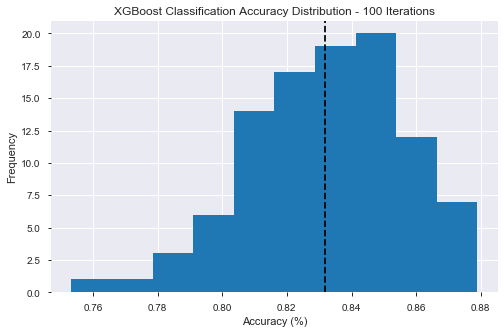

In [54]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(acc_scores)
ax.axvline(x=np.mean(acc_scores), color='black', linestyle='--')
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Frequency')
ax.set_title('XGBoost Classification Accuracy Distribution - 100 Iterations');

## Make predictions on unlabeled data

First, I need to clean up the test dataset by doing the same transformations that were applied to the test set. Let's define a quick dataframe cleaner function to do this.

In [55]:
def clean_df(df):
    
    # Replace nulls with median value for age
    df.Age.fillna(df.Age.median(), inplace=True)
    
    # Separate age data into bins for every 10 years, to smooth the effect of
    # filling null ages with median age
    df['age_bins'] = pd.cut(x=df['Age'], 
                               bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],
                               labels=[5, 15, 25, 35, 45, 55, 65, 75])
    
    # Convert data type to numeric
    df['age_bins'] = df['age_bins'].astype('int64')
    
    # Drop cabin feature
    df.drop('Cabin', axis=1, inplace=True)
    
    # Since most people embarked at 'S', we will fill  null values with 'S'
    df.Embarked.fillna('S', inplace=True)
    dummies = pd.get_dummies(df.Embarked, prefix='Emb', drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
    
    # Handling sex category
    s_dummies = pd.get_dummies(df.Sex, prefix='sex', drop_first=True)
    df = pd.concat([df, s_dummies], axis=1)
    df.drop('Sex', axis=1, inplace=True)
    
    # Drop name and ticket features
    df.drop(['Name', 'Ticket'], axis=1, inplace=True)
    
    # Drop age and passengerid
    df.drop(['Age', 'PassengerId'], axis=1, inplace=True)
    
    # Feature Engineering 'Alone'
    df['Alone'] = np.where((df['SibSp'] + df['Parch']) == 0, 1, 0)
    df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    
    return df

In [56]:
test = clean_df(test)

Below I check the pandas profiling report to see if there are any issues

In [57]:
pp.ProfileReport(test)

It looks like there is one null value in the 'Fare' category. Likely was intended to be a zero(?)

In [58]:
test.Fare.fillna(0, inplace=True)

In [59]:
test.Fare.isna().sum()

0

Now I can use the test dataset to predict on the unlabeled data.

In [60]:
final_clf = XGBClassifier(**best_xgb_params)
final_clf.fit(X_train, y_train)
final_preds = final_clf.predict(test)

In [61]:
submission = pd.DataFrame([])

In [62]:
submission['PassengerId'] = test_index
submission['Survived'] = final_preds

In [65]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [66]:
submission.to_csv('submission.csv')